# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import sys
sys.path.append('../')  # Add parent directory to the Python path

import package_DBR
import package_LAB

from importlib import reload
package_DBR = reload (package_DBR)
package_LAB = reload(package_LAB)

from package_LAB import *
from package_DBR import *


# Open/Closed-Loop Simulations

### Simulation Parameters

In [2]:
# Simulation Parameters
TSim = 2700          # Total simulation time
Ts=1                 # Sampling time
N = int(TSim/Ts)+1   #simulation steps
alpha = 1 #0.27      # Filter coefficient : T_FD = alpha*T_D
MVMin = 0
MVMax = 100

# Working Point
MV0 = 50             #Manipulated V, Process V, Disturbance V
PV0 = 46.55           # from our own experience 52.5
DV0 = 50


#--------Process------------
# Values from "Identification of SOPDT Model."
# In-Out Dynamics
Kp = 0.4             # Process gain (affect MV and PV)
T1p = 147.32            # speed of the process response
T2p = 17.23          # Slight delay in the response
thetap = 5          # Dead time : time delay between MV change and PV change.time delay between MV change and PV change.


# Disturbance Dynamics
Kd = 0.27            #  Disturbance gain : Affects the impact of the disturbance on PV.
T1d = 176            #  how quickly the disturbance affects the PV.
T2d = 44             #  delay in the disturbance effect
thetad = 6.44        #  Dead time : time delay between a change in the disturbance and its effect on PV


#----------Controller-----------
# Tuning§
gamma = 0.6           # Tuning parameter for the IMC
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

Kc = Kc/2   # to adjust the integral spike

print('Kc = ', Kc)   # Controller gain : contrôle temps de réaction, aussi l'erreur statique mais celle-ci +facile a corriger avec Integral.
print('Ti = ', Ti)   # Controller integral time constant : Gradual and continuing action until a zero steady-state response E=0 (increasing Ti = decreasing Integral Action)
print('Td = ', Td)   # Controller derivative time constant :  faster response to process changes

print('T1d/Ti, T2d/TI = ', T1d/Ti, " , ", T2d/Ti)  # needs to be < 0.25


Kc =  2.2024102706869964
Ti =  164.54999999999998
Td =  15.42584989364935
T1d/Ti, T2d/TI =  1.0695837131570953  ,  0.26739592828927383


### OLP/CLP Scenarios (Paths)

In [3]:
# # Scenario 1: OLP + no FF
ManPath = {0: True, TSim: True}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, TSim: PV0}
DVPath = {0: 50, 1000: 60, TSim: 60}
ActivateFF = False
ManFF = False

# Scenario 2: OLP + FF
# ManPath ={0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath ={0: PV0, TSim: PV0}
# DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
# ActivateFF = True
# ManFF = True

## Scenario 3: CLP + no FF
# ManPath= {0: True, 500: False, TSim: False} 
# MVManPath ={0: MV0+10, TSim: MV0+10} 
# SPPath ={0: PV0+5, 1000: PV0-5, TSim: PV0-5} 
# DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
# ActivateFF = False
# ManFF = False

# # Scenario 4: CLP + FF
# ManPath = {0: True, 500: False, TSim: False} 
# MVManPath = {0: MV0+10, TSim: MV0+10} 
# SPPath = {0: PV0+5, 1500: PV0-5, TSim: PV0-5} 
# DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10}
# ActivateFF = True
# ManFF = False



### Open/Closed-loop simultion PID with or without FF

In [4]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []
MVFFDelay = []
MVFFLL1 = []
MVDelayp = []
PV1p = []
PV2p = []
MVDelayd = []
PV1d = []
PV2d = []


for i in range(0, N):
    t.append(i*Ts)
    
    # Inputs SP, DV
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)
    
    
    # Feedforward   voir schema vert rouge bleu
    Delay_RT(DV - DV0*np.ones_like(DV), np.max([thetad-thetap, 0]), Ts, MVFFDelay)
    LL_RT(MVFFDelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else:
        LL_RT(MVFFLL1, 0, T2p, T2d, Ts, MVFF)



    # PID control action
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath, t, MVMan)
    # print("Kc = ", Kc)
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=PV0, method='EBD-EBD')
    
    
    
    # Input-output dynamics P(s)========== delay + 2 FO
    Delay_RT(MV, thetap, Ts, MVDelayp,MV0)
    FO_RT(MVDelayp, Kp, T1p, Ts, PV1p,0)
    FO_RT(PV1p,1 ,T2p, Ts, PV2p, 0)       #Lead Lag ???
    
    
    
    # Disturbance dynamics D(s)========== delay + 2 FO
    Delay_RT(DV - DV0*np.ones_like(DV), thetad, Ts, MVDelayd, 0)
    FO_RT(MVDelayd, Kd, T1d, Ts, PV1d,0)
    FO_RT(PV1d,1,T2d, Ts, PV2d, 0)
    
    
    PV.append(PV2p[-1]+ PV2d [-1]+ PV0 - Kp*MV0) # PV0 = Kp*MV0 + 0 + PV0 - Kp*MV0



E =  []   \len(E) =  0 Rest =  0.0


### CLP/OLP Plot

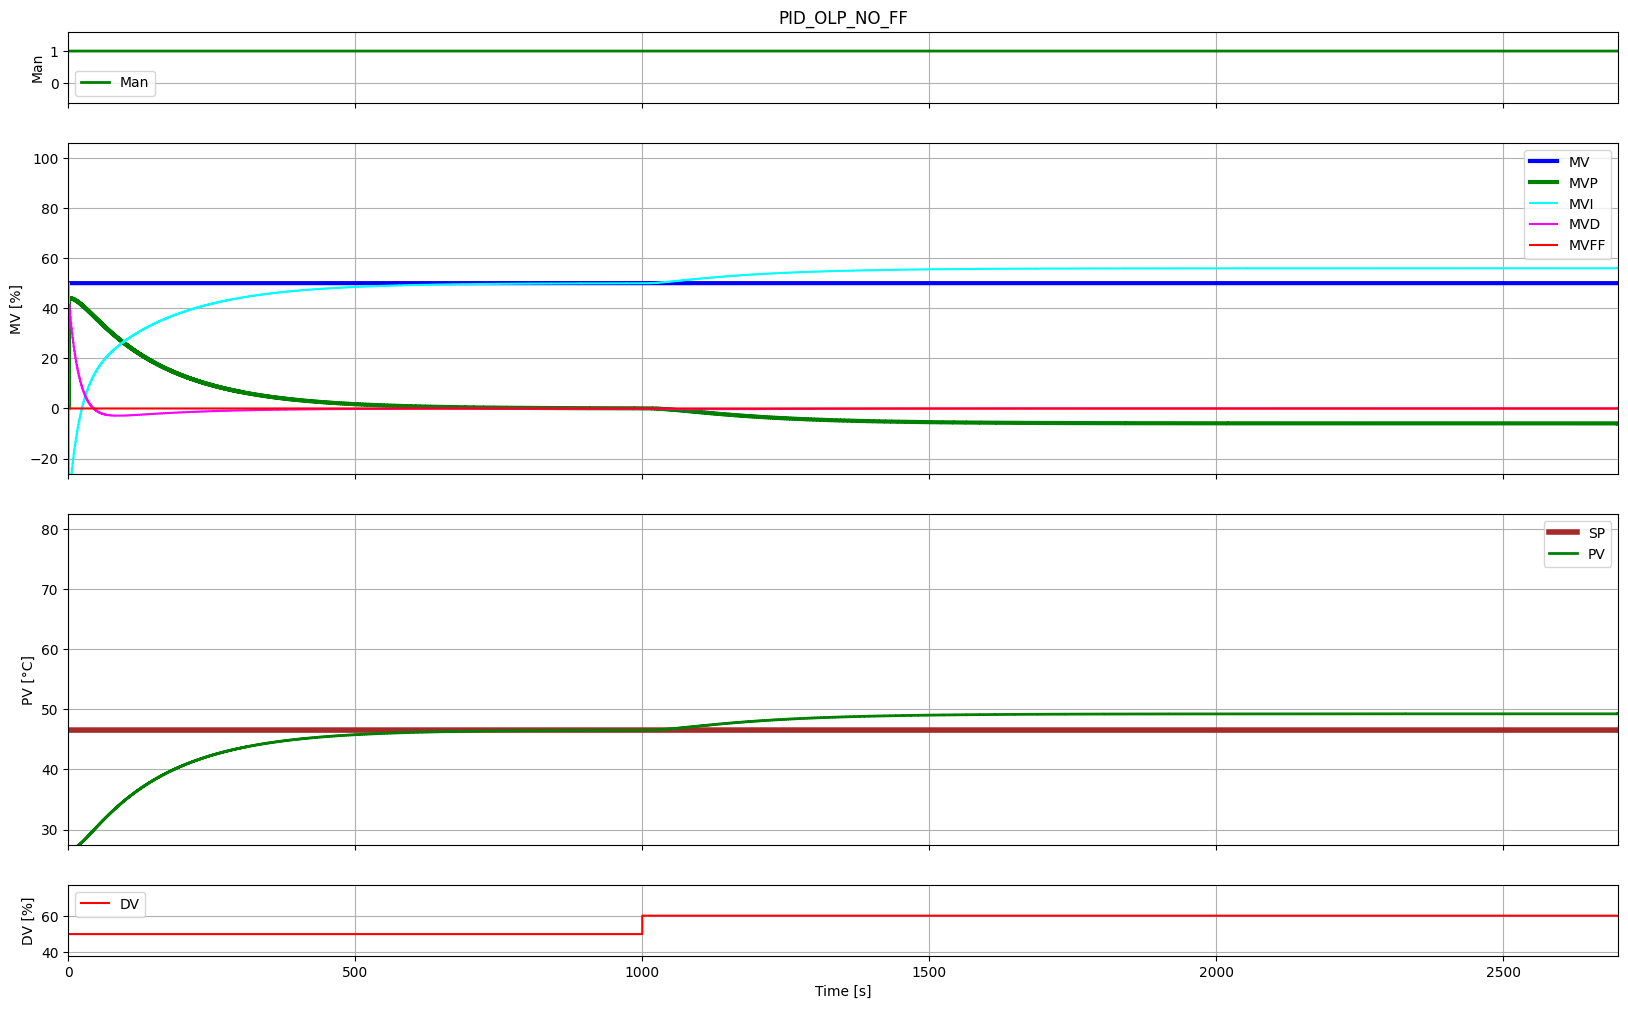

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,ncols=1, sharex='col', gridspec_kw={'height_ratios': [1.5, 7, 7, 1.5]})
fig.set_figheight(12)
fig.set_figwidth(20)

ax1.set_title('PID_OLP_NO_FF')

#------MAN--------
limSup = 1.5
limInf = -0.5
l1, = ax1.step([0,TSim], [limInf,limSup], 'green',linewidth=2, label='Man', where="post")
ax1.set_ylabel('Man')
ax1.legend (loc='best')

#-------MV_MVP_MVI_MVD_MVFF--------------
limSup = 100
limInf = -20
l2, = ax2.step([0, TSim], [limInf,limSup], 'blue', linewidth=3, label='MV', where='post') 
l3, = ax2.step([0, TSim], [limInf,limSup], 'green', linewidth=3, label='MVP', where='post') 
l4, = ax2.step([0, TSim], [limInf,limSup], 'cyan', label='MVI', where='post')
l5, = ax2.step([0, TSim], [limInf,limSup], 'magenta', label='MVD', where='post')
l6, = ax2.step([0, TSim], [limInf,limSup], 'red', label='MVFF', where='post') 
ax2.set_ylabel('MV [%]')
ax2.legend (loc='best')


#----SP_and_PV---------
limSup = 80
limInf = 30
l7, = ax3.step([0, TSim], [limInf,limSup], 'brown', linewidth=4, label='SP', where="post")
l8, = ax3.step([0, TSim], [limInf,limSup], 'green', linewidth=2, label='PV', where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend (loc='best')

#-------DV-------------
limSup=75
limInf = 40
l9, = ax4.step([0, TSim], [limInf,limSup], 'red', label='DV', where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend (loc='best')


#-----Set Data-----
l1.set_data(t, Man)
l2.set_data(t,MV)
l3.set_data(t, MVP)
l4.set_data(t,MVI)
l5.set_data(t, MVD)
l6.set_data(t, MVFF)
l7.set_data(t, SP)
l8.set_data(t, PV)
l9.set_data(t, DV)

tMax = len(t)
ax1.set_xlim(0, tMax)
ax2.set_xlim(0, tMax)
ax3.set_xlim(0, tMax)
ax4.set_xlim(0, tMax)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()



In [6]:
# Simulation Parameters
TSim = 2700          # Total simulation time
Ts=1                 # Sampling time
N = int(TSim/Ts)+1   #simulation steps
alpha = 1 #0.27      # Filter coefficient : T_FD = alpha*T_D
MVMin = 0
MVMax = 100

# Working Point
MV0 = 50             #Manipulated V, Process V, Disturbance V
PV0 = 46.55           # from our own experience 52.5
DV0 = 50


#--------Process------------
# Values from "Identification of SOPDT Model."
# In-Out Dynamics
Kp = 0.4             # Process gain (affect MV and PV)
T1p = 147.32            # speed of the process response
T2p = 17.23          # Slight delay in the response
thetap = 5          # Dead time : time delay between MV change and PV change.time delay between MV change and PV change.


# Disturbance Dynamics
Kd = 0.27            #  Disturbance gain : Affects the impact of the disturbance on PV.
T1d = 176            #  how quickly the disturbance affects the PV.
T2d = 44             #  delay in the disturbance effect
thetad = 6.44        #  Dead time : time delay between a change in the disturbance and its effect on PV


#----------Controller-----------
# Tuning§
gamma = 0.6           # Tuning parameter for the IMC
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

Kc = Kc/2   # to adjust the integral spike

print('Kc = ', Kc)   # Controller gain : contrôle temps de réaction, aussi l'erreur statique mais celle-ci +facile a corriger avec Integral.
print('Ti = ', Ti)   # Controller integral time constant : Gradual and continuing action until a zero steady-state response E=0 (increasing Ti = decreasing Integral Action)
print('Td = ', Td)   # Controller derivative time constant :  faster response to process changes

print('T1d/Ti, T2d/TI = ', T1d/Ti, " , ", T2d/Ti)  # needs to be < 0.25


Kc =  2.2024102706869964
Ti =  164.54999999999998
Td =  15.42584989364935
T1d/Ti, T2d/TI =  1.0695837131570953  ,  0.26739592828927383
